In [13]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'jpg'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
import cupy as cp

import pickle

import mne

import glob

import scipy as sp
import scipy.signal
import scipy.io

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

import tqdm

from crosspy.preprocessing.signal import filter_data
from crosspy.core.phase import compute_instantaneous_frequency
from crosspy.core.autocorrelation import get_length_by_cdf
import crosspy.core.autocorrelation as cca

from utils.pac import compute_pac_spectrum, _pac_kernel, compute_pac_with_lags
from utils.pac import transform_to_cdf, get_length_by_cdf
from utils.colornoise import powerlaw_psd_gaussian
from utils.colors import okabe, noise_color, ripples_blue, ripples_red, ripples_orange
from utils.signal_stats import compute_amplitude_spectrum

In [2]:
np.random.seed(42)

In [3]:
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe)

In [4]:
submission_data_path = r'L:\nttk-data3\palva\Vlad\meso_submission_data'

In [5]:
sfreq = 1000
time = 60

lags_cycles = np.arange(0, 10, 0.1)
f_vals_pac = np.geomspace(2,99, 81)
pac_lags_cycles = np.arange(200)/10

In [6]:
noise_data = powerlaw_psd_gaussian(1, size=(100, 60*sfreq))
noise_data -= noise_data.mean(axis=-1, keepdims=True)

In [7]:
noise_pac = compute_pac_spectrum(noise_data, f_vals_pac, sfreq, lags_cycles, omega=7.5, disable_tqdm=True)
noise_level = lags_cycles[(noise_pac <= 0.3).argmax(axis=-1)].mean(axis=-1)

In [8]:
seq_omegas = np.arange(1,11)

low_omega = 3
high_omega = 7.5

seq_pxx_by_omega = np.zeros((len(seq_omegas), 100, 2049))
seq_pac_by_omega = np.zeros((len(seq_omegas), len(f_vals_pac), noise_data.shape[0], len(lags_cycles)))
seq_amp_by_omega = np.zeros((len(seq_omegas), len(f_vals_pac), noise_data.shape[0]))

seq_components = np.zeros((len(seq_omegas), *noise_data.shape), dtype=complex)

bar = tqdm.tqdm(total=len(seq_omegas))

for omega_idx, n_segments in enumerate(seq_omegas):
    filter_omegas = [low_omega]*n_segments + [high_omega]

    data_osc = noise_data.copy()
    component = noise_data.copy()

    for omega in filter_omegas:
        component_filtered = filter_data(component, sfreq, 10, omega=omega, n_jobs='cuda').get()
        component = component_filtered.real / np.abs(component_filtered).mean(axis=-1, keepdims=True)
    
    seq_components[omega_idx] = component_filtered.copy()
    
    data_osc += component
    f_psd, seq_pxx_by_omega[omega_idx] = sp.signal.welch(data_osc, fs=sfreq, nperseg=256*16)
    
    seq_amp_by_omega[omega_idx] = compute_amplitude_spectrum(data_osc, f_vals_pac, sfreq, lags_cycles, omega=7.5, disable_tqdm=True)
    seq_pac_by_omega[omega_idx] = compute_pac_spectrum(data_osc, f_vals_pac, sfreq, lags_cycles, omega=7.5, disable_tqdm=True)
    bar.update(1)

for i in range(1, 11):
    seq_components[i - 1] = filter_data(noise_data, sfreq, 10, omega=i, n_jobs='cuda').get()
    seq_components[i - 1] /= np.abs(seq_components[i-1]).mean(axis=-1, keepdims=True)

100%|██████████| 10/10 [03:10<00:00, 19.60s/it]

In [12]:
seq_pac_by_omega_length = lags_cycles[(seq_pac_by_omega <= 0.3).argmax(axis=-1)]

In [20]:
snr_pxx_by_omega = np.zeros((3, 100, 2049))
snr_pac_by_omega = np.zeros((3, len(f_vals_pac), data_osc.shape[0], len(lags_cycles)))
snr_amp_by_omega = np.zeros((3, len(f_vals_pac), data_osc.shape[0]))

snr_sim_data = np.zeros((3, *noise_data.shape))

with cp.cuda.Device(1):
    for snr_idx, snr in enumerate([5,10,15]):
        data_osc = noise_data.copy()

        component = filter_data(data_osc, sfreq, 10, 10, n_jobs='cuda').real.get()*snr
        data_osc += component

        snr_sim_data[snr_idx] = component.copy()

        f_psd, snr_pxx_by_omega[snr_idx] = sp.signal.welch(data_osc, fs=sfreq, nperseg=256*16)

        data_pac = np.zeros((len(f_vals_pac), data_osc.shape[0], len(lags_cycles)))

        for freq_idx, freq in tqdm.tqdm_notebook(enumerate(f_vals_pac), total=len(f_vals_pac)):
            data_complex = filter_data(data_osc, sfreq, freq, 7.5, n_jobs='cuda')

            data_if = compute_instantaneous_frequency(data_complex, sr=sfreq).mean(axis=-1)

            snr_amp_by_omega[snr_idx, freq_idx] = cp.abs(data_complex).mean(axis=-1).get()
            data_complex /= cp.abs(data_complex)

            freq_pac = compute_pac_with_lags(data_complex, lags_cycles, data_if, sr=sfreq)
            snr_pac_by_omega[snr_idx, freq_idx] = freq_pac

C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [21]:
snr_sim_data_plot = np.zeros((3, 3000))
snr_sim_data_plot[0] = snr_sim_data[0,0,3500:6500].copy()
snr_sim_data_plot[1] = snr_sim_data[1,5,6000:9000].copy()
snr_sim_data_plot[2] = snr_sim_data[2,5,:3000].copy()

snr_pac_by_omega_lengths = lags_cycles[(snr_pac_by_omega <= 0.3).argmax(axis=-1)]
seq_pac_by_omega_lengths = lags_cycles[(seq_pac_by_omega <= 0.3).argmax(axis=-1)].squeeze()

In [25]:
data_path = os.path.join(submission_data_path, 'figure_1/pac_data.pickle')
pac_data = pickle.load(open(data_path, 'rb'))

pac_cdf = cca.transform_to_cdf(pac_data['pac'].mean(axis=0))

n_bins=50
thetas_bins = np.linspace(-np.pi,np.pi, n_bins+1)
thetas_mids = (thetas_bins[1:] + thetas_bins[:-1])/2

counts_1, _ = np.histogram( np.angle(pac_data['lag_1']), bins=thetas_bins, density=True)
counts_3, _ = np.histogram( np.angle(pac_data['lag_3']), bins=thetas_bins, density=True)

signal_phase = np.angle(pac_data['signal'])

pac_mean = pac_data['pac'].mean(axis=0)

C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide


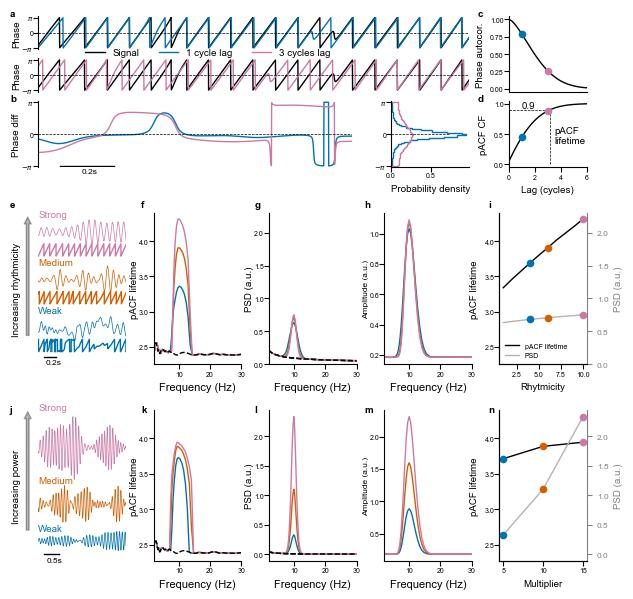

In [28]:
n_ts = 2000


fig = plt.figure(figsize=(7.08,7.08), dpi=100)
widths = [1, 1, 1]
heights = [0.4, 0.4, 1.2, 2, 2, 2]
spec = fig.add_gridspec(ncols=15, nrows=3, wspace=2.5, hspace=0.3,
                          height_ratios=[1,1,1])

gs_top = spec[0, :15].subgridspec(nrows=3, ncols=5, hspace=0.2, wspace=0.5, height_ratios=[1,1,2])

axes = np.empty((5,5), dtype=object)

axes[0,0] = fig.add_subplot(gs_top[0, :4])
axes[1,0] = fig.add_subplot(gs_top[1, :4])
axes[2,0] = fig.add_subplot(gs_top[2, :3])
axes[0,2] = fig.add_subplot(gs_top[2, 3])
axes[2,1] = fig.add_subplot(gs_top[2, 4])
axes[2,2] = fig.add_subplot(gs_top[:2, 4])

for row in range(1, 3):
    for col in range(5):
        axes[row+2, col] = fig.add_subplot(spec[row, col*3:(col+1)*3])

axes[0,0].plot(np.arange(n_ts)/sfreq, np.angle(np.roll(pac_data['signal'], 0)[:n_ts]), color=noise_color)
axes[0,0].plot(np.arange(n_ts)/sfreq, np.angle(np.roll(pac_data['signal'], 0)[100:n_ts+100]), color=ripples_blue)

axes[1,0].plot(np.arange(n_ts)/sfreq, np.angle(np.roll(pac_data['signal'], 0)[:n_ts]), color=noise_color)
axes[1,0].plot(np.arange(n_ts)/sfreq, np.angle(np.roll(pac_data['signal'], 0)[300:n_ts+300]), color=ripples_red)


axes[0,2].hist(np.angle(pac_data['lag_1']), bins=thetas_bins, density=True, histtype='step', color=ripples_blue, orientation='horizontal')
_ = axes[0,2].hist( np.angle(pac_data['lag_3']), bins=thetas_bins, density=True, histtype='step', color=ripples_red, orientation='horizontal')

axes[0,2].plot([0, 0.75], [0,0], ls='--', color='black', lw=0.5)

axes[2,0].plot(np.arange(n_ts)/sfreq, np.angle(pac_data['lag_1'][100:n_ts+100]), color=ripples_blue, label='1 Cycle')
axes[2,0].plot(np.arange(n_ts)/sfreq, np.angle(pac_data['lag_3'][300:n_ts+300]), color=ripples_red, label='3 Cycles')

axes[2,2].plot(np.arange(250)/10, pac_mean, color='black')

axes[2,2].scatter([1], [pac_mean[10]], s=20, color=ripples_blue, zorder=10)
axes[2,2].scatter([3], [pac_mean[30]], s=20, color=ripples_red, zorder=10)

axes[2,1].plot(np.arange(250)/10, pac_cdf, color='black')
axes[2,1].scatter([1], [pac_cdf[10]], s=20, color=ripples_blue, zorder=10)
axes[2,1].scatter([3], [pac_cdf[30]], s=20, color=ripples_red, zorder=10)

axes[2,1].plot([0, 3.2], [0.9, 0.9], ls='--', color='black', lw=0.5)
axes[2,1].plot([3.2, 3.2], [0, 0.9], ls='--', color='black', lw=0.5)

legend_elements = [Line2D([0], [0], color='black', label='Signal'),
                   Line2D([0], [0], color=ripples_blue, label='1 cycle lag'),
                   Line2D([0], [0], color=ripples_red, label='3 cycles lag')]

axes[0,0].legend(handles=legend_elements, loc=(0.1, -0.35), frameon=False, ncol=3, fontsize=7)

seq_n_ts_plot = 1500
n_ts_plot = 3000
    
offset = 0
for omega_idx, wavelet_idx, chan_idx, color,  label in zip([0,5,9], [1,3,9],[4,5,12], okabe, ['Weak', 'Medium','Strong']):
    y_ts_phase = np.angle(seq_components[wavelet_idx, chan_idx, :seq_n_ts_plot])/3 + offset
    offset += 3
    
    y_ts = seq_components[wavelet_idx, chan_idx, :seq_n_ts_plot].real + offset
    
    offset += 5
    
    axes[3,0].plot(np.arange(seq_n_ts_plot)/sfreq, y_ts, label=label, color=color, lw=0.5)
    axes[3,0].plot(np.arange(seq_n_ts_plot)/sfreq, y_ts_phase, label=label, color=color, lw=1)
    
    axes[3,1].plot(f_vals_pac + 0.25, np.clip(seq_pac_by_omega_length[omega_idx].mean(axis=(-1)), noise_level, None), label=label, color=color)
    axes[3,2].plot(f_psd, np.sqrt(seq_pxx_by_omega[omega_idx].mean(axis=0)), color=color)
    axes[3,2].plot(f_psd, np.sqrt(0.09/f_psd), color='black', ls='--')
    axes[3,3].plot(f_vals_pac, seq_amp_by_omega[omega_idx].mean(axis=-1), color=color)
    
    axes[3,0].text(0.0, offset - 2.5, label, color=color, fontsize=7)

for omega_idx, label, color, offset in zip(range(3), ['Weak', 'Medium','Strong'], okabe, [0, 5.5, 14]):
    y_ts = snr_sim_data_plot[omega_idx, :n_ts_plot] + offset
    axes[4,0].plot(np.arange(n_ts_plot)/sfreq, y_ts, label=label, lw=0.5)
    
    axes[4,1].plot(f_vals_pac, np.clip(snr_pac_by_omega_lengths[omega_idx].mean(axis=(-1)), noise_level, None), label=label)
    axes[4,2].plot(f_psd, snr_pxx_by_omega[omega_idx].mean(axis=0))
    axes[4,2].plot(f_psd, 0.09/f_psd, color='black', ls='--')
    axes[4,3].plot(f_vals_pac, snr_amp_by_omega[omega_idx].mean(axis=-1))
    
    axes[4,0].text(0.0, y_ts.max()*1.05, label, color=color, fontsize=7)
    
axes[3,1].plot(f_vals_pac, noise_level, ls='--', color='black')
axes[4,1].plot(f_vals_pac, noise_level, ls='--', color='black')
    
growth_twin_axes = [axes[3,4].twinx(), axes[4,4].twinx()]

line_legend = list()

line_legend += axes[3,4].plot(seq_omegas,seq_pac_by_omega_length[:,32].mean(axis=-1), color='black', label='pACF lifetime')
line_legend += growth_twin_axes[0].plot(seq_omegas, np.sqrt(seq_pxx_by_omega[...,41].mean(axis=-1)), color=(0.7,0.7,0.7), label='PSD')


for seq_idx in [3,5,9]:
    axes[3,4].scatter(seq_omegas[[seq_idx]],seq_pac_by_omega_length[:,32].mean(axis=-1)[[seq_idx]], s=20, zorder=10)
    growth_twin_axes[0].scatter(seq_omegas[[seq_idx]], np.sqrt(seq_pxx_by_omega[...,41].mean(axis=-1)[[seq_idx]]), s=20, zorder=10)

axes[4,4].plot([5,10,15], snr_pac_by_omega_lengths[:, 32].mean(axis=-1), color='black')
growth_twin_axes[1].plot([5,10,15], snr_pxx_by_omega[...,41].mean(axis=-1), color=(0.7,0.7,0.7))

for snr_idx in range(3):
    axes[4,4].scatter([(snr_idx+1)*5], [snr_pac_by_omega_lengths[snr_idx, 32].mean(axis=-1)], s=20, zorder=10)
    growth_twin_axes[1].scatter([(snr_idx+1)*5], [snr_pxx_by_omega[snr_idx, :, 41].mean(axis=-1)], s=20, zorder=10)

axes[3,4].legend(line_legend, [l.get_label() for l in line_legend], frameon=False, fontsize=5)
# axes[4,4].legend(line_legend, [l.get_label() for l in line_legend], frameon=False, fontsize=6)

for ax in axes[:3, 0]:
    ax.plot([0, 2], [0,0], ls='--', color='black', lw=0.5)

for ax in [axes[3,2], axes[4,2]]:
    ax.yaxis.set_minor_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.minorticks_off()
    
for ax in axes[:3, 0]:
    ax.set_xticks([])
    ax.spines['bottom'].set_visible(False)

for ax in axes[[2],0]:
    ax.set_ylim([-np.pi*1.05, np.pi*1.05])
    

for ax in axes[:3, 0].tolist() + [axes[0,2]]:
    ax.set_yticks([-np.pi, 0,  np.pi])
    ax.set_yticklabels([r'$-\pi$', '0',  r'$\pi$'])
    
for ax in filter(lambda x: not(x is None), axes.flatten()):
    ax.tick_params(labelsize=5, pad=0)

for ax in axes[3:, 1:4].flatten():
    ax.set_xlabel('Frequency (Hz)', fontsize=8)
    ax.set_xlim([2,30])

for ax in [ax for ax in axes.flatten() if ax != axes[0,2] and not(ax is None)] + [axes[0,2]]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for ax in [axes[0, 0], axes[2, 0]]:
    ax.spines['bottom'].set_visible(False)    
    ax.set_xlim([0, n_ts/sfreq])

for ax in axes[3:, 0]:
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    
    
axes[3,0].set_xlim([0, seq_n_ts_plot/sfreq])
axes[4,0].set_xlim([0, n_ts_plot/sfreq])

axes[3,0].set_xticks([])
axes[4,0].set_xticks([])

axes[3,0].spines['bottom'].set_visible(False)
axes[4,0].spines['bottom'].set_visible(False)

###

axes[2,0].plot([0.1,0.35], [-np.pi, -np.pi], color='black', lw=1)
axes[2,0].text(0.2, -np.pi - 0.7, '0.2s', color='black', fontsize=6)

axes[3,0].plot([0.1,0.3], [-2, -2], color='black', lw=1)
axes[3,0].text(0.125, -3.15, '0.2s', color='black', fontsize=6)

axes[4,0].plot([0.2,0.7], [-2, -2], color='black', lw=1)
axes[4,0].text(0.275, -3.15, '0.5s', color='black', fontsize=6)

###

axes[0,2].set_ylim([-np.pi*1.05, np.pi*1.05])
    
axes[2,0].set_xlim([0, 1.45])
axes[2,2].set_ylabel('Phase autocor.', fontsize=7)

axes[2,1].set_xlabel('Lag (cycles)', fontsize=7)
axes[2,1].set_ylabel('pACF CF', fontsize=7)

axes[2,1].set_xlim([0,6])

axes[0,2].grid(False)

axes[2,2].set_xlim([0,6])

for ax in axes[3:, 1]:
    ax.set_yticks([2.5, 3.0, 3.5, 4.0])

axes[0,0].set_xlim([0,2.0])
axes[1,0].set_xlim([0,2.0])
    
axes[2,0].set_ylabel('Angle', fontsize=7, labelpad=0)
axes[3,1].set_ylabel('pACF lifetime', fontsize=7, labelpad=0)
axes[4,1].set_ylabel('pACF lifetime', fontsize=7, labelpad=0)

axes[3,2].set_ylabel('PSD (a.u.)', fontsize=7, labelpad=0)
axes[4,2].set_ylabel('PSD (a.u.)', fontsize=7, labelpad=0)

axes[3,3].set_ylabel('Amplitude (a.u.)', fontsize=6, labelpad=0)
axes[4,3].set_ylabel('Amplitude (a.u.)', fontsize=6, labelpad=0)

axes[3,0].set_ylabel('Increasing rhythmicity', fontsize=7, labelpad=12.5)
axes[4,0].set_ylabel('Increasing power', fontsize=7, labelpad=12.5)

axes[0,0].set_ylabel('Phase', fontsize=7, labelpad=0)
axes[1,0].set_ylabel('Phase', fontsize=7, labelpad=0)
axes[2,0].set_ylabel('Phase diff', fontsize=7, labelpad=0)
axes[0,2].set_xlabel('Probability density', fontsize=7)

arrow = mpl.patches.FancyArrowPatch(
    (0.11, 0.15), (0.11, 0.325),  # Place arrow in figure coord system
    fc = "black", arrowstyle='simple', alpha = 0.3,
    mutation_scale = 10., transform=fig.transFigure
)
# 5. Add patch to list of objects to draw onto the figure
fig.patches.append(arrow)

arrow2 = mpl.patches.FancyArrowPatch(
    (0.11, 0.425), (0.11, 0.6),  # Place arrow in figure coord system
    fc = "black", arrowstyle='simple', alpha = 0.3,
    mutation_scale = 10., transform=fig.transFigure
)

fig.patches.append(arrow2)

axes[3,1].set_ylim((2.25, 4.4))
axes[3,4].set_ylim((2.25, 4.4))

axes[3,2].set_ylim([0,2.3])
growth_twin_axes[0].set_ylim([0, 2.3])

axes[4,1].set_ylim((2.27175, 4.4))
axes[4,4].set_ylim((2.27175, 4.4))

axes[2,2].set_xticks([])
axes[2,1].text(1, 0.925, '0.9', fontsize=7)
axes[2,1].text(3.5, 0.35, 'pACF\nlifetime', fontsize=7)

growth_twin_axes[1].set_ylim(axes[4,2].get_ylim())

for ax, xlabel in zip(axes[3:, 4], ['Rhytmicity', 'Multiplier']):
    ax.set_xlabel(xlabel, fontsize=7)
    ax.set_ylabel('pACF lifetime', fontsize=7)
    ax.spines['top'].set_visible(False)


for ax in filter(lambda x: not(x is None), axes[2:, 1:].flatten().tolist()):
    ax.tick_params(axis='x', pad=1)
    
for ax in growth_twin_axes:
    ax.set_ylabel('PSD (a.u.)', fontsize=7, color=(0.5, 0.5, 0.5))
    ax.spines['top'].set_visible(False)
    
    ax.spines['right'].set_color((0.5, 0.5, 0.5))
    ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])

    ax.tick_params(axis='y', which='both', labelsize=6, colors=(0.5, 0.5, 0.5))
    
for ax in axes[3:, 4]:
    ax.set_yticks([2.5, 3.0, 3.5, 4.0])

for label, ypos in zip(['a','b'], [0.88, 0.76]):
    fig.text(0.085, ypos, label, fontsize=7, weight='bold')
    
for label, ypos in zip(['c','d'], [0.88, 0.76]):
    fig.text(0.745, ypos, label, fontsize=7, weight='bold')

for label, ypos in zip(['e', 'j'], [0.61, 0.32]):
    fig.text(0.085, ypos, label, fontsize=7, weight='bold')

for label, xpos in zip(['f', 'g', 'h', 'i',], [0.27, 0.43, 0.585, 0.76]):
    fig.text(xpos, 0.61, label, fontsize=7, weight='bold')
    
for label, xpos in zip('klmn', [0.27, 0.43, 0.585, 0.76]):
    fig.text(xpos, 0.32, label, fontsize=7, weight='bold')
    
fig.savefig('publication_figures/figure_1.png', dpi=300, bbox_inches="tight")

for format in ['svg', 'pdf']:
    fig_path = os.path.join('publication_figures', 'vector', f'figure_1.{format}')
    fig.savefig(fig_path, dpi=300, bbox_inches="tight")

## Supp figure 1

In [29]:
baseline_omega_values = np.linspace(4, 10, 25)
baseline_as_omega_lifetime = np.zeros((25, 100))
baseline_as_omega_pac = np.zeros((25, 100, 100))
    
for omega_idx, omega in enumerate(tqdm.tqdm(baseline_omega_values)):    
    data_complex = filter_data(noise_data, sfreq, 10, omega, n_jobs='cuda')
    
    data_complex /= cp.abs(data_complex)
    
    data_if = compute_instantaneous_frequency(data_complex, sfreq).mean(axis=-1)
    
    freq_pac = compute_pac_with_lags(data_complex, lags_cycles, data_if, sr=sfreq)
    freq_lifetime = lags_cycles[(freq_pac <= 0.2).argmax(axis=-1)]
    
    baseline_as_omega_pac[omega_idx] = freq_pac
    baseline_as_omega_lifetime[omega_idx] = freq_lifetime

100%|██████████| 25/25 [00:03<00:00,  7.76it/s]


In [30]:
data_osc = noise_data.copy()

component = filter_data(data_osc, sfreq, 10, 10, n_jobs='cuda').real.get()*5
data_osc += component

In [31]:
baseline_omega_values = np.linspace(4, 10, 25)
peak_width_as_omega_pac = np.zeros((25, len(f_vals_pac), 100, 100))

for omega_idx, omega in enumerate(tqdm.tqdm(baseline_omega_values)):    
    peak_width_as_omega_pac[omega_idx] = compute_pac_spectrum(data_osc, f_vals_pac, sfreq, lags_cycles, omega=omega, disable_tqdm=True)

100%|██████████| 25/25 [04:25<00:00, 10.62s/it]


In [32]:
peak_width_as_omega_lifetime = lags_cycles[(peak_width_as_omega_pac <= 0.1).argmax(axis=-1)]
peak_width_as_omega_sign = (peak_width_as_omega_lifetime >= peak_width_as_omega_lifetime[:, :6].mean(axis=(1,-1)).reshape(-1,1,1)*1.2)

In [33]:
peak_width_as_omega = np.zeros((25,100))

for i in range(25):
    for j in range(100):
        sign_indices = np.where(peak_width_as_omega_sign[i,:,j])[0]
        min_freq, max_freq = f_vals_pac[[sign_indices.min(), sign_indices.max()]]
        peak_width_as_omega[i,j] = max_freq - min_freq

C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


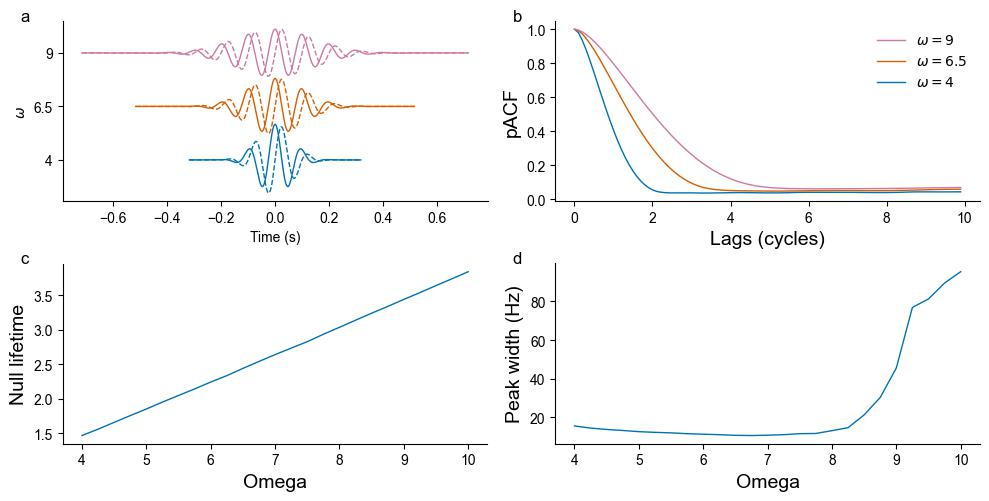

In [34]:
fig = plt.figure(figsize=(10,5))

spec = fig.add_gridspec(ncols=4, nrows=2)

ax_morlet = fig.add_subplot(spec[0, :2])
ax_baseline = fig.add_subplot(spec[0, 2:])
ax_baseline_line = fig.add_subplot(spec[1, :2])
ax_peak_width = fig.add_subplot(spec[1, 2:])

ax_morlet.plot((np.arange(1433) - 1433/2)/1000, mne.time_frequency.morlet(1000, [10], 9)[0].real + 0.4, color=ripples_red, label=r'$\omega=9$')
ax_morlet.plot((np.arange(1035) - 1035/2)/1000, mne.time_frequency.morlet(1000, [10], 6.5)[0].real + 0.2, color=ripples_orange, label=r'$\omega=6.5$')
ax_morlet.plot((np.arange(637) - 637/2)/1000, mne.time_frequency.morlet(1000, [10], 4)[0].real, color=ripples_blue, label=r'$\omega=4$')

ax_morlet.plot((np.arange(1433) - 1433/2)/1000, mne.time_frequency.morlet(1000, [10], 9)[0].imag + 0.4, ls='--', color=ripples_red)
ax_morlet.plot((np.arange(1035) - 1035/2)/1000, mne.time_frequency.morlet(1000, [10], 6.5)[0].imag + 0.2, ls='--', color=ripples_orange)
ax_morlet.plot((np.arange(637) - 637/2)/1000, mne.time_frequency.morlet(1000, [10], 4)[0].imag, ls='--', color=ripples_blue)

ax_baseline.plot(lags_cycles, baseline_as_omega_pac.mean(axis=1)[[0,10,20]].T)

ax_baseline_line.plot(baseline_omega_values, baseline_as_omega_lifetime.mean(axis=-1))
ax_peak_width.plot(baseline_omega_values, peak_width_as_omega.mean(axis=-1))

ax_baseline_line.set_xlabel('Omega', fontsize=14)
ax_baseline_line.set_ylabel('Null lifetime', fontsize=14)

ax_peak_width.set_ylabel('Peak width (Hz)', fontsize=14)
ax_peak_width.set_xlabel('Omega', fontsize=14)

ax_baseline.set_xlabel('Lags (cycles)', fontsize=14)
ax_baseline.set_ylabel('pACF', fontsize=14)

# ax_morlet.legend(frameon=False)

ax_morlet.set_xlabel('Time (s)')
ax_morlet.set_yticklabels(['', '4', '6.5', '9'])
ax_morlet.set_ylabel(r'$\omega$')

legend_elements = [Line2D([0], [0], color=color, label=label) for color, label in 
                   zip([ripples_red, ripples_orange, ripples_blue], [r'$\omega=9$', r'$\omega=6.5$', r'$\omega=4$'])]

ax_baseline.legend(handles=legend_elements, frameon=False)

for ax in fig.axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()

for ax, label in zip(fig.axes, 'abcd'):
    ax.text(-0.1, 1, label, transform=ax.transAxes, fontsize=12)

fig.savefig('publication_figures/figure_1_supp.png', dpi=300, bbox_inches="tight")